<a href="https://colab.research.google.com/github/JVCarmich0959/CSC228/blob/main/Transformers_Intent_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Build a Text Classification / Intent Classification
# Owner: Jacquelyn Carmichael
# Based on Hugging Face and Dr. Tomek's examples
# Date: 2021-05-25

# link to my github repo: https://github.com/JVCarmich0959/CSC228/blob/main/College_Questions%20-%20Sheet1.csv
# https: //huggingface.co/


# Import necessary libraries and tools

In [ ]:
# Import PyTorch for tensor manipulation
import torch

# Import Pandas for data manipulation and handling
import pandas as pd

# Import softmax function for probability computation
from torch.nn.functional import softmax

# Import Hugging Face Transformers classes for model handling and training
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments,
    pipeline,
)

# Import scikit-learn classes for data preprocessing and evaluation
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

# Import specific Hugging Face Transformers classes for BERT model
from transformers import (
    BertTokenizer,
    BertForSequenceClassification,
    Trainer,
    TrainingArguments,
)


# Load a dataset of questions and their categories from a GitHub link.

In [ ]:
# Define the URL for the dataset hosted on GitHub
url = 'https://raw.githubusercontent.com/JVCarmich0959/CSC228/main/Intent_Classification_College_Questions%20-%20Sheet1.csv'

# Load the dataset into a Pandas DataFrame by reading from the URL
df = pd.read_csv(url)


# Split the dataset into training and testing sets, so the model can learn from one part and be tested on another

In [ ]:
# Split the data into training and testing
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

# Pre-process and tokenize the text in the dataset, which means converting the words into a format the model can understand.

In [ ]:
# Instantiate a BERT tokenizer using the pre-trained "bert-base-uncased" model
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

# Tokenize the training dataset questions and apply truncation and padding
train_encodings = tokenizer(train_df['Questions'].tolist(), truncation=True, padding=True)

# Tokenize the testing dataset questions and apply truncation and padding
test_encodings = tokenizer(test_df['Questions'].tolist(), truncation=True, padding=True)


# Encode the categories (or "intents") of the questions into numbers

In [ ]:
# Instantiate a LabelEncoder for encoding intent labels
le = LabelEncoder()

# Fit the LabelEncoder on the training dataset intent labels and transform them into numerical labels
train_labels = le.fit_transform(train_df['Intent Labels'])

# Transform the test dataset intent labels into numerical labels using the fitted LabelEncoder
test_labels = le.transform(test_df['Intent Labels'])


# Create a custom dataset with the tokenized text and encoded categories.

In [ ]:
# Define a custom PyTorch Dataset class for the tokenized data and labels
class IntentDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    # Get an item from the dataset by index
    def __getitem__(self, idx):
        # Create a dictionary with encodings for the item at the given index
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        
        # Add the corresponding label to the item dictionary
        item['labels'] = torch.tensor(self.labels[idx])
        
        # Return the item dictionary
        return item

    # Get the length of the dataset (number of items)
    def __len__(self):
        return len(self.labels)

# Create training and testing datasets using the custom PyTorch Dataset class
train_dataset = IntentDataset(train_encodings, train_labels)
test_dataset = IntentDataset(test_encodings, test_labels)


# Loading the pre-trained BERT model

BERT is a popular machine learning model for understanding language. It was trained on a huge amount of text from Wikipedia and other sources, and it also used for predictive text like on our cellphones.

# Training Parameters:

Training parameters allow you to finetune the model to your specific dataset. You can change the number of epochs, the learning rate, and the batch size.

In [ ]:
# Fine-tune a BERT model for sequence classification using the Hugging Face Trainer
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=len(le.classes_))

# Define training arguments for fine-tuning
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    save_strategy="epoch",
    load_best_model_at_end=True,
    evaluation_strategy="epoch"
)

# Instantiate the Hugging Face Trainer with the model, training arguments, and datasets
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset
)

# Start the fine-tuning process
trainer.train()


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 1.4738280773162842, 'eval_runtime': 0.2024, 'eval_samples_per_second': 49.403, 'eval_steps_per_second': 9.881, 'epoch': 1.0}
{'loss': 1.7591, 'learning_rate': 1.0000000000000002e-06, 'epoch': 2.0}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 1.4729316234588623, 'eval_runtime': 0.1574, 'eval_samples_per_second': 63.517, 'eval_steps_per_second': 12.703, 'epoch': 2.0}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 1.473083257675171, 'eval_runtime': 0.1433, 'eval_samples_per_second': 69.772, 'eval_steps_per_second': 13.954, 'epoch': 3.0}
{'train_runtime': 17.7661, 'train_samples_per_second': 6.754, 'train_steps_per_second': 0.844, 'train_loss': 1.7499298095703124, 'epoch': 3.0}


TrainOutput(global_step=15, training_loss=1.7499298095703124, metrics={'train_runtime': 17.7661, 'train_samples_per_second': 6.754, 'train_steps_per_second': 0.844, 'train_loss': 1.7499298095703124, 'epoch': 3.0})

In [ ]:
# Save the fine-tuned BERT model to a directory named "fine_tuned_bert"
model.save_pretrained("fine_tuned_bert")

# Save the LabelEncoder's class labels to a file named "label_encoder_classes.npy"
le.classes_.dump("label_encoder_classes.npy")


In [ ]:
# Extract the unique intent labels from the DataFrame
intents = df['Intent Labels'].unique().tolist()

# Extract the list of questions (utterances) from the DataFrame
utterances = df['Questions'].tolist()


# Zero shot Classification

What is it?

Zero shot classification is a method of classification where you don't have to train a model on the data. You can use a pre-trained model and use it to classify your data. This is useful when you don't have enough data to train a model on

How does it work?

The model is trained on a dataset of text and labels. The model is then used to classify new text. The model will output a probability for each label. The label with the highest probability is the one that the model thinks the text belongs to.


# BART-Large-MNLI

BART-Large-MNLI is a pre-trained model that was trained on the MNLI dataset. The MNLI dataset is a dataset of text and labels. The labels are either "entailment", "neutral", or "contradiction". This provides a good starting point for zero shot classification, and "transfer learning".



# Calling our pipeline

In [ ]:
# Instantiate the zero-shot classifier
zero_shot_classifier = pipeline("zero-shot-classification", model="facebook/bart-large-mnli")

# The predict_intent function:
I use this to predict the category of a question using the pipeline we just instanced above. The function takes in a question and returns the predicted category.

In [ ]:
# Define a function to predict the intent of a given text using the zero-shot classifier
def predict_intent(text):
    # Use the zero-shot classifier to make a prediction for the input text
    prediction = zero_shot_classifier(text, intents, multi_label=True)
    
    # Return the top predicted label from the prediction results
    return prediction['labels'][0]


In [ ]:
# Get predictions and add them to the DataFrame
df['Zero-Shot Prediction'] = [predict_intent(u) for u in utterances]

In [ ]:
# Predict categories for test set questions using zero-shot classifier
test_df['Zero-Shot Prediction'] = [predict_intent(u) for u in test_df['Questions']]

# Function to predict category using fine-tuned BERT model
def predict_intent_bert(text):
    # Tokenize input text
    inputs = tokenizer(text, padding=True, truncation=True, return_tensors="pt")
    
    # Get model output for tokenized text
    outputs = model(**inputs)
    
    # Extract logits from model output
    logits = outputs.logits
    
    # Compute softmax probabilities from logits
    softmax_probs = softmax(logits, dim=1)
    
    # Find index of highest probability for predicted category
    predicted_label_idx = torch.argmax(softmax_probs, dim=1)
    
    # Convert predicted index back to category label
    predicted_label = le.inverse_transform(predicted_label_idx)
    
    # Return predicted category label
    return predicted_label[0]

# Get predictions for all questions in dataset using fine-tuned BERT model
df['BERT Prediction'] = [predict_intent_bert(u) for u in utterances]

# Predict categories for test set questions using fine-tuned BERT model
test_df['BERT Prediction'] = [predict_intent_bert(u) for u in test_df['Questions']]

# Predict catefories for test set questions using zero-shot classifier
test_df['Zero-Shot Prediction'] = [predict_intent(u) for u in test_df['Questions']]

In [ ]:
df[:5]


,Intent Labels,Questions,Contexts,Answers,Zero-Shot Prediction,BERT Prediction
13,Student_Activities,What is the purpose of clubs and organizations...,Students come to Wayne Community College to ge...,Clubs and organizations provide social and aca...,Student_Activities,Admissions
39,About_College,How does Wayne Community College contribute to...,For more than 60 years students have passed th...,WCC provides access to high-quality education ...,About_College,Admissions
30,About_College,What degrees and programs are offered at Wayne...,For more than 60 years students have passed th...,"WCC offers more than 165 degree, diploma, cer...",About_College,Admissions
45,Admissions,How can I send my transcripts to Wayne Communi...,New Student\nStep 1 – Complete Application\nAp...,Transcripts can be sent electronically to wcc-...,About_College,Admissions
17,Student_Activities,What amenities are available in the student lo...,Students come to Wayne Community College to ge...,The student lounge includes a wide-screen tele...,Student_Activities,Admissions


In [ ]:
test_df[:5]

,Intent Labels,Questions,Contexts,Answers,Zero-Shot Prediction,BERT Prediction
13,Student_Activities,What is the purpose of clubs and organizations...,Students come to Wayne Community College to ge...,Clubs and organizations provide social and aca...,Student_Activities,Admissions
39,About_College,How does Wayne Community College contribute to...,For more than 60 years students have passed th...,WCC provides access to high-quality education ...,About_College,Admissions
30,About_College,What degrees and programs are offered at Wayne...,For more than 60 years students have passed th...,"WCC offers more than 165 degree, diploma, cer...",About_College,Admissions
45,Admissions,How can I send my transcripts to Wayne Communi...,New Student\nStep 1 – Complete Application\nAp...,Transcripts can be sent electronically to wcc-...,About_College,Admissions
17,Student_Activities,What amenities are available in the student lo...,Students come to Wayne Community College to ge...,The student lounge includes a wide-screen tele...,Student_Activities,Admissions


In [ ]:
# Import evaluation metrics from the sklearn library
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

# Get the true intent labels from the test dataset
true_labels = test_df['Intent Labels']

# Calculate accuracy scores for both the zero-shot and BERT models
zero_shot_accuracy = accuracy_score(true_labels, test_df['Zero-Shot Prediction'])
bert_accuracy = accuracy_score(true_labels, test_df['BERT Prediction'])

# Calculate weighted F1 scores for both models
zero_shot_f1 = f1_score(true_labels, test_df['Zero-Shot Prediction'], average='weighted')
bert_f1 = f1_score(true_labels, test_df['BERT Prediction'], average='weighted')

# Calculate weighted precision scores for both models
zero_shot_precision = precision_score(true_labels, test_df['Zero-Shot Prediction'], average='weighted')
bert_precision = precision_score(true_labels, test_df['BERT Prediction'], average='weighted')

# Calculate weighted recall scores for both models
zero_shot_recall = recall_score(true_labels, test_df['Zero-Shot Prediction'], average='weighted')
bert_recall = recall_score(true_labels, test_df['BERT Prediction'], average='weighted')



/Users/jvcarmichael94/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jvcarmichael94/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# Print evaluation metrics for both the Zero-Shot and BERT models

# Display performance metrics for the Zero-Shot model
print("Zero-Shot Model Performance:")
print(f"Accuracy: {zero_shot_accuracy}")  # Print the accuracy score of the Zero-Shot model
print(f"F1-score: {zero_shot_f1}")        # Print the F1-score of the Zero-Shot model
print(f"Precision: {zero_shot_precision}")  # Print the precision score of the Zero-Shot model
print(f"Recall: {zero_shot_recall}")      # Print the recall score of the Zero-Shot model

# Add an empty line to separate the two model's performance metrics
print("\nBERT Model Performance:")

# Display performance metrics for the BERT model
print(f"Accuracy: {bert_accuracy}")       # Print the accuracy score of the BERT model
print(f"F1-score: {bert_f1}")             # Print the F1-score of the BERT model
print(f"Precision: {bert_precision}")     # Print the precision score of the BERT model
print(f"Recall: {bert_recall}")           # Print the recall score of the BERT model


Zero-Shot Model Performance:
Accuracy: 0.7
F1-score: 0.6333333333333333
Precision: 0.65
Recall: 0.7

BERT Model Performance:
Accuracy: 0.2
F1-score: 0.06666666666666668
Precision: 0.04
Recall: 0.2


In [ ]:
#import classification_report from sklearn library
from sklearn.metrics import classification_report

# Get the true intent labels from the test dataset
true_labels = test_df['Intent Labels']

#  Print classification report for more detailed results
print("\nZero-Shot Model Classification Report:")
print(classification_report(true_labels, test_df['Zero-Shot Prediction']))

print("\nBERT Model Classification Report:")
print(classification_report(true_labels, test_df['BERT Prediction']))


Zero-Shot Model Classification Report:
                    precision    recall  f1-score   support

     About_College       0.50      1.00      0.67         3
        Admissions       0.00      0.00      0.00         2
     Financial_Aid       1.00      0.50      0.67         2
Student_Activities       1.00      1.00      1.00         3

          accuracy                           0.70        10
         macro avg       0.62      0.62      0.58        10
      weighted avg       0.65      0.70      0.63        10


BERT Model Classification Report:
                    precision    recall  f1-score   support

     About_College       0.00      0.00      0.00         3
        Admissions       0.20      1.00      0.33         2
     Financial_Aid       0.00      0.00      0.00         2
Student_Activities       0.00      0.00      0.00         3

          accuracy                           0.20        10
         macro avg       0.05      0.25      0.08        10
      weighted avg  

/Users/jvcarmichael94/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jvcarmichael94/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jvcarmichael94/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start,

In simple terms, the Zero-Shot Model did much better than the BERT Model when trying to figure out the categories of some questions. The Zero-Shot Model was right about 70% of the time, while the BERT Model was only right 20% of the time.

The Zero-Shot Model did a great job at guessing some categories, like "Financial_Aid" and "Student_Activities," but not so great for "Admissions." The BERT Model didn't do well at guessing any of the categories, except it was kind of okay for "Admissions."

But remember, we only looked at 10 questions to see how well the models did. It's hard to say for sure which one is better with so few questions. We should test the models on more questions and maybe make some adjustments to the BERT Model to see if it can do better.






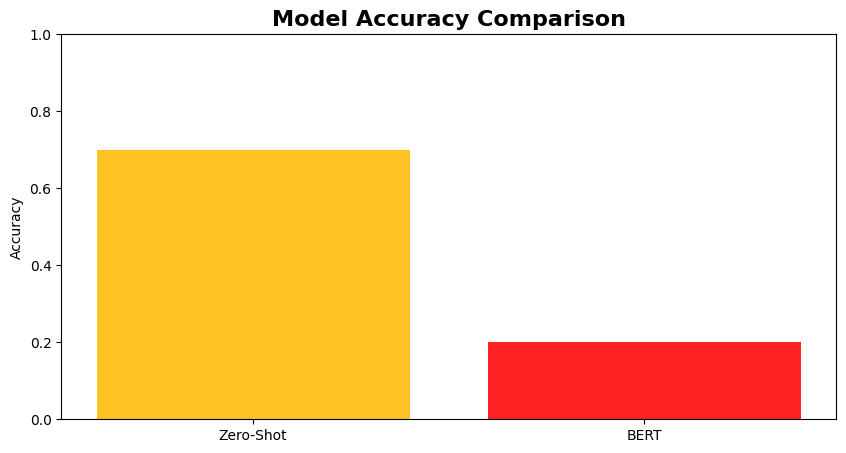

In [ ]:
import matplotlib.pyplot as plt

# Use ggplot to visualize the results
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(111)
ax.bar(['BART', 'BERT'], [zero_shot_accuracy, bert_accuracy], color=['#FFC222', '#FF2222'])
ax.set_ylim([0, 1])
ax.set_ylabel('Accuracy')
ax.set_title('Model Accuracy Comparison', fontsize=16, fontweight='bold')
plt.show()



# BERT vs Zero Shot Classifier




## Strengths of the Zero-Shot Model:

1. **Better overall accuracy**: It performed better in classifying the questions into the correct categories compared to the BERT Model.

2. **No fine-tuning needed**: This model does not require training on the specific dataset, making it more convenient to use.


## Weaknesses of the Zero-Shot Model:


1. **Inconsistent performance**: While it performed well for some categories, it struggled with others, like "Admissions."

2. **Limited generalization**: Its performance can be affected by the nature of  the dataset, especially if the dataset contains very specific or unique categories.

## Strengths of the BERT Model:

1. **Customizable**: It can be fine-tuned to perform better on specific tasks or datasets.

2. **Potential for high performance**: With proper fine-tuning and training, it can achieve high accuracy and other performance metrics.

## Weaknesses of the BERT Model:

1.  **Poor performance in this case**: It had a low accuracy score, and it struggled to classify questions into the correct categories.

2. **Requires fine-tuning**: It needs to be trained on the specific dataset, which can be time-consuming and computationally expensive.


# My Conclusions:

The performannce of the Zero-Shot classifier and the BERT model in the domain of a college chatbot can greatly impact the overall user experience and efficiency of the chatbot. Both models are designed to handle natural language understanding tasks and can be applied to intent classification problems, which are crucial for chatbots to accurately interpret and respond to user queries. The Zero-Shot classifier, as the name suggests, does not require any fine-tuning or training on the specific dataset. This makes it more convenient to use, especially if the dataset is large and complex, making it an attractive choice for developers who are looking for a quick and effective way to get started with a college chatbot.

The Zero-Shot classifier's strength lies in its ability to provide reasonable performance without requiring any fine-tuning or labeled data. This can be advantageous when building a chatbot in a new domain or with limited resources. However, this model's weakness is that it may not always provide the best possible performance compared to models that have been fine-tuned for the
specific task. As a result, it may sometimes misinterpret user queries or provide less accurate responses in some situations. Despite this, the Zero-Shot classifier can still be a valuable tool for developers lookign to quickly build a
college chatbot with minimal training data and resources.

On the other hand, the BERT model is a powerful and highly accurate language model that can provide better performance when fine-tuned for a specific task or domain, such as intent classification for a college chatbot. By leveraging pre-trained knowledge and adapting it to the specific domain, the BERT model can offer more accurate and context-aware responses to user queries. However, the BERT model requires labeled data and additional fine-tuning, which can be resource-intensive and time-consuming. This may not be ideal for developers with limited resources or tight deadlines.

In the context of a college chatbot, the BERT model's strength is its potential to provide more accurate and context-aware responses, leading to a better overall user experience. It can better understand and interpret user queries, allowing the chatbot to provide more relevant information and assistance. However, the model's weakness lies in the fact that it requires labeled data and additional fine-tuning, which can be resource-intensive and time-consuming. Furthermore, the BERT model's computational requirements are higher than those of the Zero-Shot classifier, making it less suitable for environments with limited resources.

In conclusion, both the Zero-Shot classifier and the BERT model have their strengths and weaknesses when applied to the domain of a college chatbot. The Zero-Shot classifier provides a quick and effective way to build a chatbot with minimal training data and resources, while the BERT model can offer more accurate and context-aware responses when fine-tuned for the specific task. Developers should carefully consider their resources, requirements, and the desired level of performance when choosing between these models for building a college chatbot. Ultimately, the right choice depends on the specific needs and constraints of the project.